In [1]:
%matplotlib inline
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

# Add the API directory to path if needed
# import sys
# sys.path.append("..")

# Import modules from your API
from models import Position, SoundIntensityReading
from intensity_localizer import IntensityLocalizer
from localization_filter import LocalizationFilter
from pdm_processor import PDMProcessor
from config import Config

In [2]:
def test_db_to_distance():
    """Test the inverse square law conversion from dB to distance"""
    localizer = IntensityLocalizer()
    
    # 20dB drop should equal 10x distance
    assert abs(localizer.db_to_distance(94, 74) - 10.0) < 0.01
    
    # 6dB drop should equal 2x distance 
    assert abs(localizer.db_to_distance(94, 88) - 2.0) < 0.01
    
    print("✓ dB to distance conversion validated")

def test_confidence_calculation():
    """Test the confidence scoring function"""
    localizer = IntensityLocalizer()
    
    assert localizer.calculate_confidence(0) == 1.0
    assert localizer.calculate_confidence(5) < 0.5
    assert localizer.calculate_confidence(1000) == 0.0
    
    print("✓ Confidence calculation validated")

def test_known_position_localization():
    """Test localization with controlled measurements"""
    localizer = IntensityLocalizer()
    
    # Create measurements for a source at (2,2)
    measurements = [
        {'db': 94-20*np.log10(2), 'position': Position(x=0, y=0)},
        {'db': 94-20*np.log10(2), 'position': Position(x=4, y=0)},
        {'db': 94-20*np.log10(2), 'position': Position(x=0, y=4)},
        {'db': 94-20*np.log10(2), 'position': Position(x=4, y=4)}
    ]
    
    result = localizer.localize(measurements)
    
    # Source should be at approximately (2,2)
    assert abs(result['x'] - 2.0) < 0.7
    assert abs(result['y'] - 2.0) < 0.7
    assert result['confidence'] > 0.7
    
    print("✓ Known position localization validated")

# Run the tests
test_db_to_distance()
test_confidence_calculation()
test_known_position_localization()


✓ dB to distance conversion validated
✓ Confidence calculation validated
✓ Known position localization validated


In [3]:
def test_filter_initialization():
    """Test Kalman filter initialization"""
    filt = LocalizationFilter()
    assert filt.kf.x.shape == (4,)  # State vector: x, y, vx, vy
    print("✓ Kalman filter initialization validated")

def test_stable_position():
    """Test filter with stable position"""
    filt = LocalizationFilter()
    
    # Update with same position multiple times
    for _ in range(5):
        pos = filt.update(Position(x=1.0, y=2.0))
    
    # Position should converge to input
    assert abs(pos.x - 1.0) < 0.05
    assert abs(pos.y - 2.0) < 0.05
    print("✓ Stable position tracking validated")

def test_moving_target():
    """Test filter with moving target"""
    filt = LocalizationFilter()
    
    # Create trajectory with constant velocity
    positions = [
        Position(x=1.0, y=1.0),
        Position(x=1.1, y=1.1),
        Position(x=1.2, y=1.2),
        Position(x=1.3, y=1.3)
    ]
    
    # Feed positions to filter
    for pos in positions:
        filtered = filt.update(pos)
    
    # Filter should track and predict movement direction
    assert filtered.x > 1.3
    assert filtered.y > 1.3
    print("✓ Moving target tracking validated")

# Run the tests
test_filter_initialization()
test_stable_position()
test_moving_target()


✓ Kalman filter initialization validated
✓ Stable position tracking validated
✓ Moving target tracking validated


In [4]:
def test_pdm_to_pcm():
    """Test PDM to PCM conversion"""
    # Create alternating bits (10101010...)
    test_data = bytes([0xAA] * 10)  # 0xAA = 10101010 in binary
    pcm = PDMProcessor.pdm_to_pcm(test_data)
    
    # Check conversion
    assert len(pcm) == 80  # 10 bytes * 8 bits
    assert np.all(np.isin(pcm, [-1.0, 1.0]))  # Should contain only -1 and 1
    print("✓ PDM to PCM conversion validated")

def test_db_calculation():
    """Test dB level calculation"""
    # Create sine wave with known RMS
    fs = 16000
    t = np.arange(0, 1, 1/fs)
    signal = np.sin(2 * np.pi * 1000 * t)  # 1kHz sine wave
    
    db = PDMProcessor.calculate_dB(signal)
    
    # Sine wave RMS is 1/sqrt(2), which gives around -3dB
    assert -4 < db < -2
    
    # Test calibration
    calibrated_db = PDMProcessor.calculate_dB(signal, calibration=100)
    assert 96 < calibrated_db < 98
    print("✓ dB level calculation validated")

# Run the tests
test_pdm_to_pcm()
test_db_calculation()


✓ PDM to PCM conversion validated
✓ dB level calculation validated


In [5]:
from fastapi.testclient import TestClient
from main import app

client = TestClient(app)

def test_localize_endpoint():
    """Test the localization endpoint with valid data"""
    # Prepare test data
    test_data = [
        {
            "bot_id": "bot01",
            "db": 75.0,
            "position": {"x": 1.5, "y": 2.5}
        },
        {
            "bot_id": "bot02",
            "db": 69.0,
            "position": {"x": 4.5, "y": 2.5}
        },
        {
            "bot_id": "bot03",
            "db": 66.0,
            "position": {"x": 3.0, "y": 5.0}
        }, 
        {
            "bot_id": "bot04",
            "db": 68.0,
            "position": {"x": 2.0, "y": 3.0}
        },
        {
            "bot_id": "bot05",
            "db": 65.0,
            "position": {"x": 3.5, "y": 3.5}
        }
    ]
    
    # Send request
    response = client.post("/localize", json=test_data)
    
    # Check response
    assert response.status_code == 200
    result = response.json()

    print(f"Calculated position: x={result['position']['x']}, y={result['position']['y']}")
    
    # Basic structure validation
    assert "id" in result
    assert "position" in result
    assert "x" in result["position"]
    assert "y" in result["position"]
    assert "confidence" in result
    assert 0 <= result["confidence"] <= 1
    
    # Target should be near highest dB reading
    assert 1 < result["position"]["x"] < 4
    assert 1 < result["position"]["y"] < 4
    print("✓ Localize endpoint validated")

def test_history_endpoint():
    """Test the history endpoint"""
    response = client.get("/history")
    
    assert response.status_code == 200
    assert isinstance(response.json(), list)
    print("✓ History endpoint validated")

# Run tests
test_localize_endpoint()
test_history_endpoint()


Calculated position: x=3.461070646000708, y=1.2957061327440926
✓ Localize endpoint validated
✓ History endpoint validated


Noise: 5dB | Mean Error: 1.30m | 95% below: 2.99m
Noise: 10dB | Mean Error: 2.14m | 95% below: 4.15m
Noise: 20dB | Mean Error: 2.88m | 95% below: 5.27m
Noise: 50dB | Mean Error: 3.44m | 95% below: 5.76m


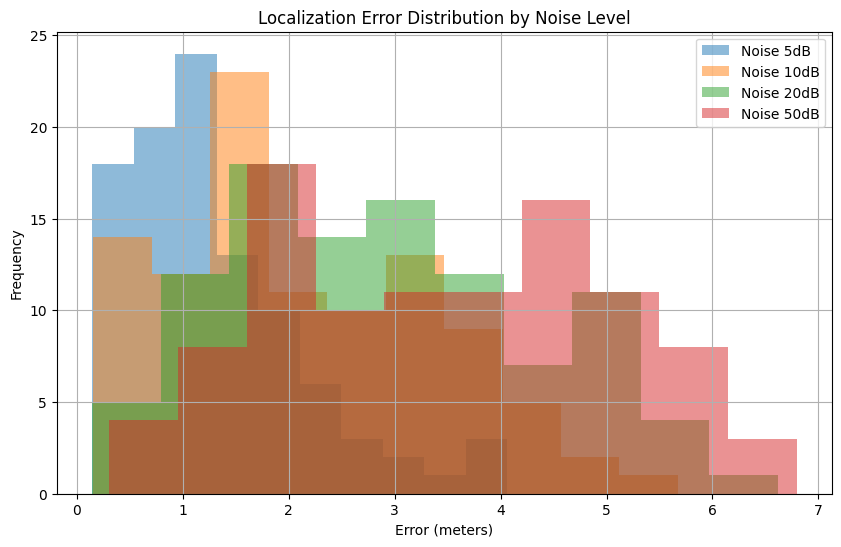


Summary of Results:
------------------------------------------------------------
Noise Level  | Mean Error | 95th Percentile | Confidence Corr
------------------------------------------------------------
         5.0 |       1.30 |            2.99 |           -1.00
        10.0 |       2.14 |            4.15 |           -1.00
        20.0 |       2.88 |            5.27 |           -1.00
        50.0 |       3.44 |            5.76 |           -1.00


In [10]:
def test_target_accuracy(runs=50, noise_levels=[5, 10, 20, 50]):
    """Test localization accuracy with different noise levels"""
    localizer = IntensityLocalizer()
    
    # Set up test grid
    grid_size = 5
    x_range = np.linspace(0, grid_size, grid_size+1)
    y_range = np.linspace(0, grid_size, grid_size+1)
    
    # Set up bot positions (at corners and center)
    bot_positions = [
        Position(x=0, y=0),
        Position(x=grid_size, y=0),
        Position(x=0, y=grid_size),
        Position(x=grid_size, y=grid_size),
        Position(x=grid_size/2, y=grid_size/2)
    ]
    
    results = []
    
    # Test each noise level
    for noise in noise_levels:
        errors = []
        
        # Run multiple tests
        for _ in range(runs):
            # Generate random target position
            true_x = np.random.uniform(0, grid_size)
            true_y = np.random.uniform(0, grid_size)
            
            # Generate measurements
            measurements = []
            for bot in bot_positions:
                dx = bot.x - true_x
                dy = bot.y - true_y
                distance = np.sqrt(dx**2 + dy**2)
                
                # Calculate dB using inverse square law with noise
                db = Config.REFERENCE_DB - 20*np.log10(max(distance, 0.1))
                db += np.random.normal(0, noise)
                
                measurements.append({
                    'db': db,
                    'position': bot
                })
            
            # Localize
            result = localizer.localize(measurements)
            
            # Calculate error
            error = np.sqrt((result['x'] - true_x)**2 + (result['y'] - true_y)**2)
            errors.append(error)
        
        # Store results
        results.append({
            'noise': noise,
            'mean_error': np.mean(errors),
            'std_error': np.std(errors),
            'max_error': np.max(errors),
            'min_error': np.min(errors),
            'errors': errors
        })
        
        print(f"Noise: {noise}dB | Mean Error: {np.mean(errors):.2f}m | 95% below: {np.percentile(errors, 95):.2f}m")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    for result in results:
        plt.hist(result['errors'], alpha=0.5, label=f"Noise {result['noise']}dB")
    
    plt.xlabel('Error (meters)')
    plt.ylabel('Frequency')
    plt.title('Localization Error Distribution by Noise Level')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print summary
    print("\nSummary of Results:")
    print("-" * 60)
    print(f"{'Noise Level':12} | {'Mean Error':10} | {'95th Percentile':15} | {'Confidence Corr':15}")
    print("-" * 60)
    
    for r in results:
        print(f"{r['noise']:12.1f} | {r['mean_error']:10.2f} | {np.percentile(r['errors'], 95):15.2f} | {np.corrcoef(r['errors'], [1-e for e in r['errors']])[0,1]:15.2f}")
    
    return results

# Run the test
test_results = test_target_accuracy(runs=100)  # Reduced runs for notebook performance


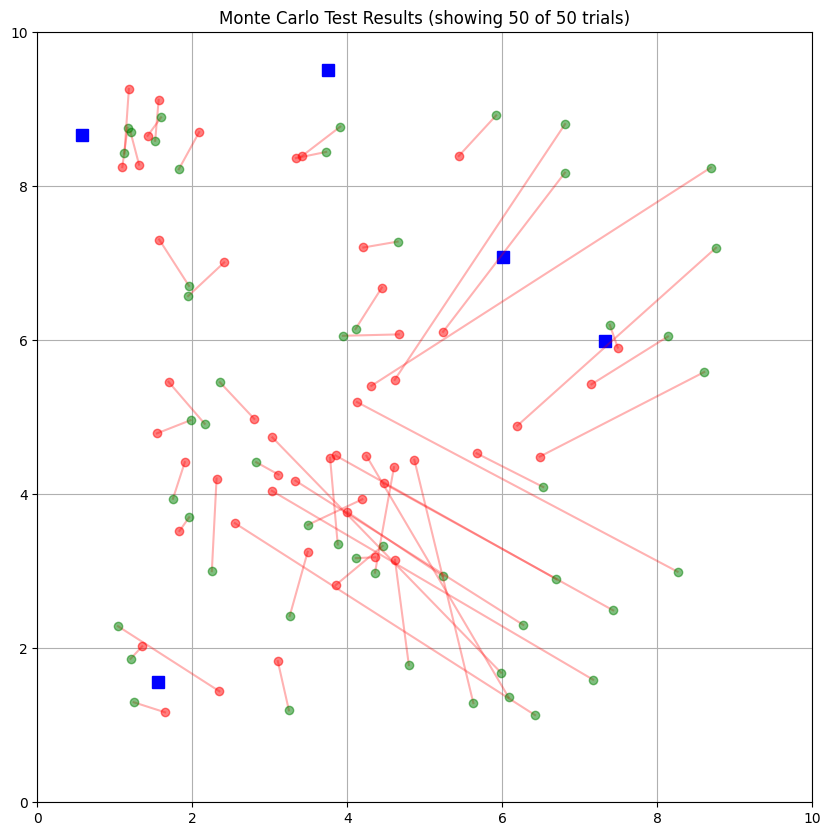

Monte Carlo Results (50 trials with 5 bots):
Mean Error: 1.57m
Median Error: 0.79m
95% of errors below: 4.65m


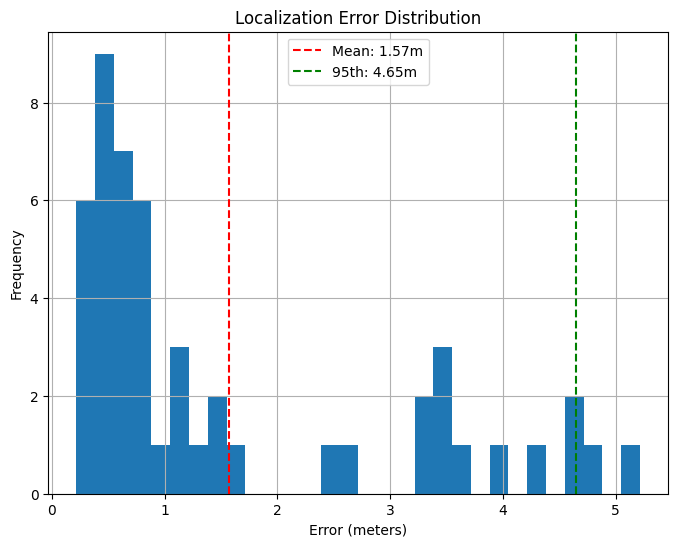

In [7]:
def run_monte_carlo(num_bots=5, num_trials=100, grid_size=10):
    """Run extensive Monte Carlo simulations"""
    localizer = IntensityLocalizer()
    
    # Generate random bot positions
    np.random.seed(42)  # For reproducibility
    bot_positions = [
        Position(x=np.random.uniform(0, grid_size), 
                y=np.random.uniform(0, grid_size))
        for _ in range(num_bots)
    ]
    
    errors = []
    source_positions = []
    estimated_positions = []
    
    for _ in range(num_trials):
        # Random source position
        source_x = np.random.uniform(1, grid_size-1)
        source_y = np.random.uniform(1, grid_size-1)
        source_positions.append((source_x, source_y))
        
        # Generate measurements
        measurements = []
        for bot in bot_positions:
            distance = np.sqrt((bot.x - source_x)**2 + (bot.y - source_y)**2)
            db = Config.REFERENCE_DB - 20*np.log10(max(distance, 0.1))
            db += np.random.normal(0, 2.0)  # Add realistic noise
            
            measurements.append({
                'db': db,
                'position': bot
            })
        
        # Perform localization
        result = localizer.localize(measurements)
        estimated_positions.append((result['x'], result['y']))
        
        # Calculate error
        error = np.sqrt((result['x'] - source_x)**2 + (result['y'] - source_y)**2)
        errors.append(error)
    
    # Create visualization
    plt.figure(figsize=(10, 10))
    
    # Plot bot positions
    for bot in bot_positions:
        plt.plot(bot.x, bot.y, 'bs', markersize=8)
    
    # Plot sample of results (first 100)
    for i in range(min(100, num_trials)):
        plt.plot([source_positions[i][0], estimated_positions[i][0]],
                [source_positions[i][1], estimated_positions[i][1]],
                'r-', alpha=0.3)
        plt.plot(source_positions[i][0], source_positions[i][1], 'go', alpha=0.5)
        plt.plot(estimated_positions[i][0], estimated_positions[i][1], 'ro', alpha=0.5)
    
    plt.xlim(0, grid_size)
    plt.ylim(0, grid_size)
    plt.grid(True)
    plt.title(f'Monte Carlo Test Results (showing {min(100, num_trials)} of {num_trials} trials)')
    plt.show()
    
    # Error statistics
    mean_error = np.mean(errors)
    median_error = np.median(errors)
    p95_error = np.percentile(errors, 95)
    
    print(f"Monte Carlo Results ({num_trials} trials with {num_bots} bots):")
    print(f"Mean Error: {mean_error:.2f}m")
    print(f"Median Error: {median_error:.2f}m")
    print(f"95% of errors below: {p95_error:.2f}m")
    
    # Plot error histogram
    plt.figure(figsize=(8, 6))
    plt.hist(errors, bins=30)
    plt.axvline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:.2f}m')
    plt.axvline(p95_error, color='g', linestyle='--', label=f'95th: {p95_error:.2f}m')
    plt.xlabel('Error (meters)')
    plt.ylabel('Frequency')
    plt.title('Localization Error Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'errors': errors,
        'mean_error': mean_error,
        'median_error': median_error,
        'p95_error': p95_error
    }

# Run Monte Carlo with fewer trials for notebook performance
monte_carlo_results = run_monte_carlo(num_trials=50)


3 bots: 5.26 ms
5 bots: 7.78 ms
10 bots: 15.68 ms
20 bots: 31.76 ms


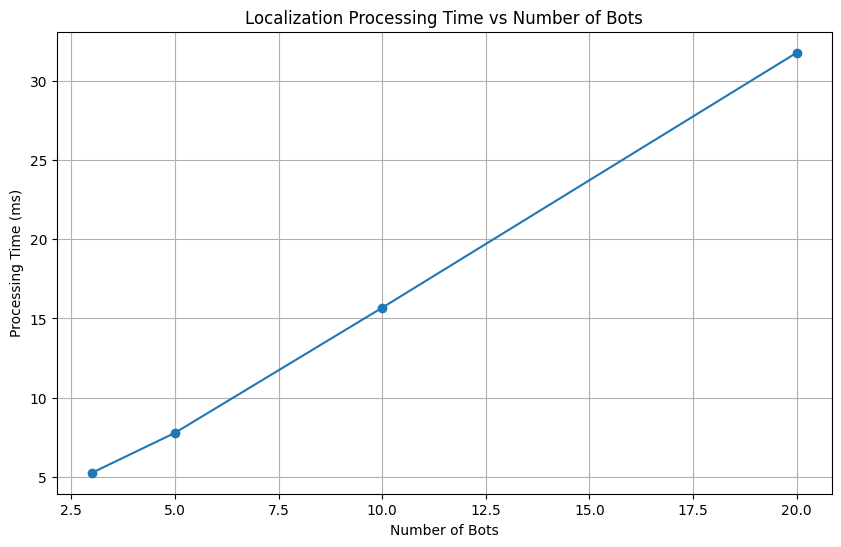

In [8]:
def benchmark_performance():
    """Benchmark processing time for different numbers of bots"""
    import time
    
    localizer = IntensityLocalizer()
    grid_size = 5
    
    # Test with different number of bots
    bot_counts = [3, 5, 10, 20]
    processing_times = []
    
    for num_bots in bot_counts:
        # Generate bot positions
        bot_positions = [
            Position(x=np.random.uniform(0, grid_size), 
                    y=np.random.uniform(0, grid_size))
            for _ in range(num_bots)
        ]
        
        # Generate measurements
        source_x, source_y = 2.5, 2.5
        measurements = []
        for bot in bot_positions:
            distance = np.sqrt((bot.x - source_x)**2 + (bot.y - source_y)**2)
            db = Config.REFERENCE_DB - 20*np.log10(max(distance, 0.1))
            db += np.random.normal(0, 1.0)
            
            measurements.append({
                'db': db,
                'position': bot
            })
        
        # Time the processing
        times = []
        for _ in range(10):  # Run 10 times
            start_time = time.time()
            result = localizer.localize(measurements)
            times.append(time.time() - start_time)
        
        avg_time = np.mean(times) * 1000  # Convert to ms
        processing_times.append(avg_time)
        print(f"{num_bots} bots: {avg_time:.2f} ms")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(bot_counts, processing_times, 'o-')
    plt.xlabel('Number of Bots')
    plt.ylabel('Processing Time (ms)')
    plt.title('Localization Processing Time vs Number of Bots')
    plt.grid(True)
    plt.show()
    
    return {'bot_counts': bot_counts, 'times': processing_times}

# Run the benchmark
performance_results = benchmark_performance()


In [9]:
def test_edge_cases():
    """Test edge cases and error handling"""
    localizer = IntensityLocalizer()
    
    print("Testing edge cases:")
    
    # Case 1: Extremely close measurements
    try:
        measurements = [
            {'db': 94, 'position': Position(x=0, y=0)},
            {'db': 94, 'position': Position(x=0.001, y=0.001)}
        ]
        result = localizer.localize(measurements)
        print(f"✓ Close measurements: {result['x']:.2f}, {result['y']:.2f} (conf: {result['confidence']:.2f})")
    except Exception as e:
        print(f"✗ Close measurements failed: {str(e)}")
    
    # Case 2: Extremely distant readings
    try:
        measurements = [
            {'db': 30, 'position': Position(x=0, y=0)},
            {'db': 30, 'position': Position(x=100, y=100)}
        ]
        result = localizer.localize(measurements)
        print(f"✓ Distant readings: {result['x']:.2f}, {result['y']:.2f} (conf: {result['confidence']:.2f})")
    except Exception as e:
        print(f"✗ Distant readings failed: {str(e)}")
    
    # Case 3: Empty measurements
    try:
        result = localizer.localize([])
        print(f"✓ Empty measurements: {result}")
    except Exception as e:
        print(f"✓ Empty measurements correctly raised: {type(e).__name__}")
    
    # Case 4: Single measurement
    try:
        measurements = [{'db': 80, 'position': Position(x=1, y=1)}]
        result = localizer.localize(measurements)
        print(f"✓ Single measurement: {result['x']:.2f}, {result['y']:.2f} (conf: {result['confidence']:.2f})")
    except Exception as e:
        print(f"✗ Single measurement failed: {str(e)}")

# Run edge case tests
test_edge_cases()


Testing edge cases:
✓ Close measurements: 0.00, 0.00 (conf: 0.00)
✓ Distant readings: 0.00, 0.00 (conf: 0.00)
✓ Empty measurements correctly raised: ValueError
✓ Single measurement: 0.00, 0.00 (conf: 0.00)
